# Demonstration notebook 
In this notebook, we demonstrate the usage of Chronocell on a simulated dataset and generate the plots for Figure 1. 

We simulate data from the bifurcation topology in figure 1 (topo = np.array([[0,1,2],[0,1,3]])), fit it with our Trajectory model, and plot the results. 

In [1]:
import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *

2023.09.01


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import numpy as np
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from scipy.special import logsumexp, softmax
import copy
from sklearn.decomposition import PCA
import cmasher as cmr
import anndata as ad
import scanpy as sc

# Generate data

In [3]:
from Chronocell.models.two_species_ss import get_Y

np.random.seed(0)
loga_max = 4
logb_max = 2

n=1000
p=100
topo = np.array([[0,1,2],[0,1,3]])
tau = (0,1,2)

L=len(topo)
n_states=len(set(topo.flatten()))
t=np.linspace(tau[0],tau[-1],n)
true_t = []

theta=np.zeros((p,n_states+2))
for j in range(n_states):
    theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2:]=np.exp(np.random.uniform(0,logb_max,size=(p,2)))

Y = np.zeros((n*L,p,2))
for l in range(L):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
    Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
    true_t = np.append(true_t,t)

X = np.random.poisson(0.5*Y)

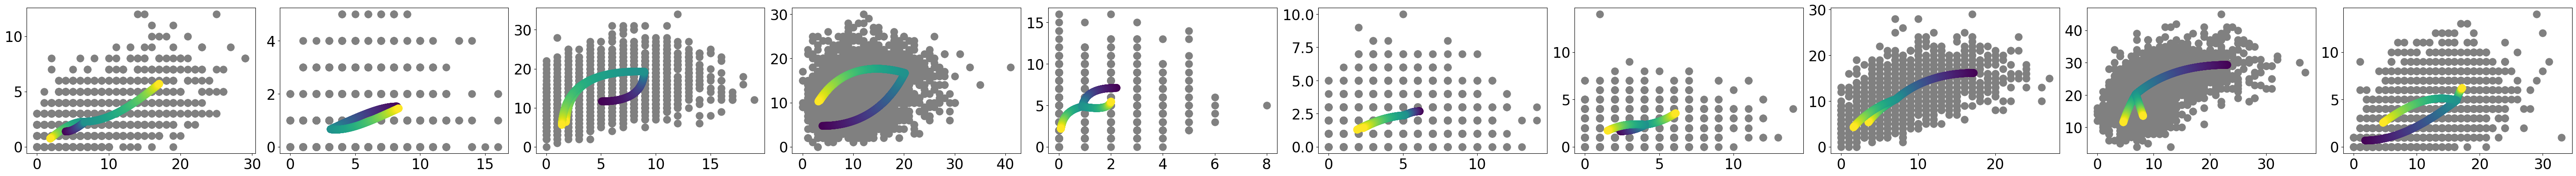

In [4]:
t = np.linspace(tau[0],tau[-1],n)
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(0.5*Y[:,i,0],0.5*Y[:,i,1],c=true_t)
    #ax[i].scatter(Y[n:,i,0],Y[n:,i,1],c=true_t[n:],cmap=cmap_2, vmin=tau[0], vmax=tau[-1]);
    #ax[i].scatter(Y[:n//2,i,0],Y[:n//2,i,1],c=t[:n//2],cmap="Purples", vmin=tau[0], vmax=tau[-1]);
# time increases from blue to red

In [5]:
traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj = traj.fit(X,warm_start=True,m=51,theta=theta,epoch=1)

Reminder: provide cellwise read depth estimates in params with key r
fitting with warm start


100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


# PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[:,:,1])

theta_hat = traj.theta.copy()
_,L,m = traj.Q.shape
Y_pca = np.zeros((L,n,2))
t_hat=np.linspace(tau[0],tau[-1],n)
Y = traj.get_Y_hat(theta_hat,t_hat,traj.tau,traj.topo,traj.params) # m*p*2
for l in range(L):
    Y_pca[l] = pca.transform(Y[l,:,:,1])

In [7]:
cmap_1 = cmr.get_sub_cmap('Blues', 0.1, 0.9)
cmap_2 = cmr.get_sub_cmap('Reds', 0.1, 0.9)
cmap_3 = cmr.get_sub_cmap('Greens', 0.1, 0.9)

In [8]:
color_1 = traj.Q[:,0]@np.array(cmap_1(traj.t/tau[-1]))[:,:3]
color_2 = traj.Q[:,1]@np.array(cmap_2(traj.t/tau[-1]))[:,:3]
t_color = color_1 + color_2

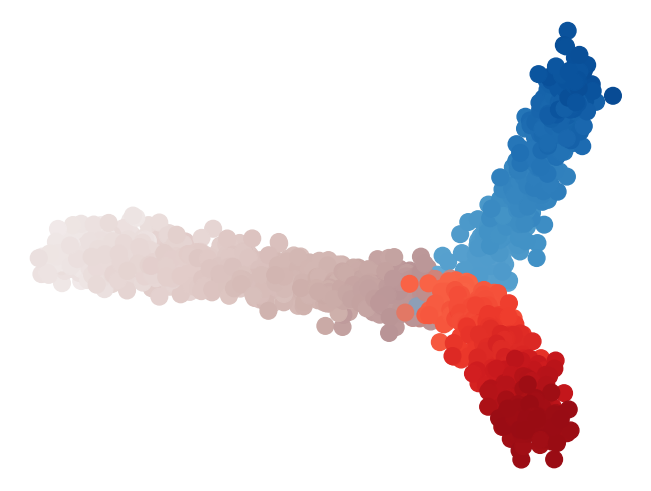

In [9]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_pca[:,0],X_pca[:,1],c=t_color[:,:3]);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

# Genes plots

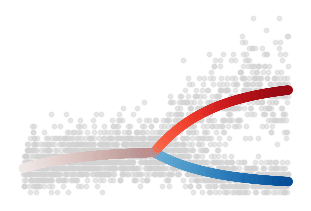

In [10]:
i=0
x = X[:,i]
x_weighted = np.zeros((L,m,2))

for l in range(len(topo)):
    weight_l = traj.Q[:,l,:]/n*m
    x_weighted[l] = weight_l.T@x / weight_l.sum(axis=0)[:,None] # m*1
    
fig = plt.figure(figsize=(3,2),facecolor='none')
plt.scatter(true_t,X[:,i,0],color="lightgray",alpha=0.5,s=10);
#plt.scatter(traj.t,x_weighted[0,:,0],color="#d3d3d3",alpha=0.8,s=10);
plt.scatter(t_hat,Y[0,:,i,0],c=t_color[:n],s=30);
plt.scatter(t_hat,Y[1,:,i,0],c=t_color[n:],s=30);
plt.axis('off');

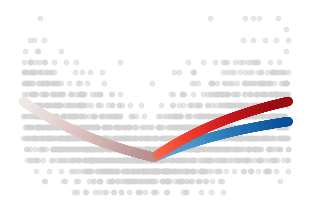

In [11]:
i=1
fig = plt.figure(figsize=(3,2),facecolor='none')
plt.scatter(true_t,X[:,i,0],color="lightgray",alpha=0.5,s=10);
#plt.scatter(traj.t,x_weighted[0,:,0],color="#d3d3d3",alpha=0.8,s=10);
plt.scatter(t_hat,Y[0,:,i,0],c=t_color[:n],s=30);
plt.scatter(t_hat,Y[1,:,i,0],c=t_color[n:],s=30);
plt.axis('off');

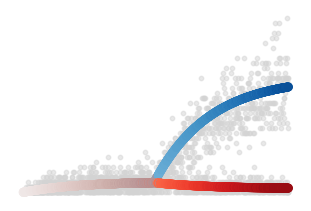

In [12]:
i=-1
fig = plt.figure(figsize=(3,2),facecolor='none')
plt.scatter(true_t,X[:,i,0],color="lightgray",alpha=0.5,s=10);
plt.scatter(t_hat,Y[0,:,i,0],c=t_color[:n,:3],s=30);
plt.scatter(t_hat,Y[1,:,i,0],c=t_color[n:,:3],s=30);
plt.axis('off');

# Posteriors

Text(0, 0.5, 'Cells')

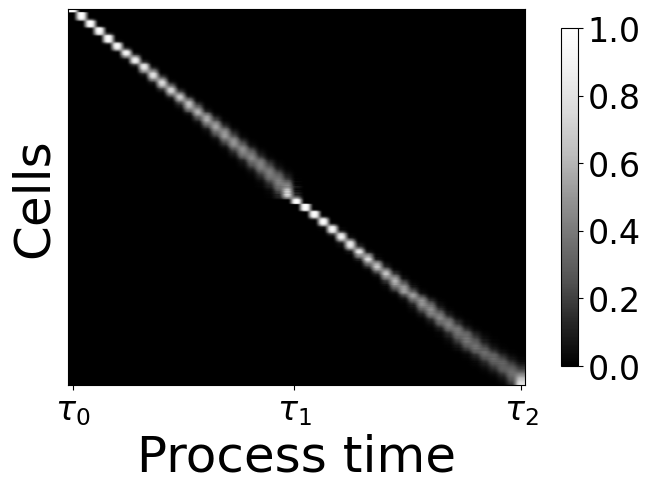

In [13]:
plt.rcParams['font.size'] = '24'

x0=0.25

def _forward(x):
    return x

def _inverse(x):
    return x

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

fig, ax = plt.subplots(1,1)

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
cell_idx = np.argsort(t_hat)
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]
im = ax.imshow(Z,aspect="auto",cmap='Greys_r',norm=norm);

cbar = plt.colorbar(im,fraction=0.2, shrink = 0.9) # adding the colobar on the right
x_label_list = [r'$\tau_0$', r'$\tau_1$', r'$\tau_2$']
ax.set_xticks(traj.tau/traj.tau[-1]*(traj.m-1))
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
ax.set_xlabel('Process time',fontsize=36)
ax.set_ylabel('Cells',fontsize=36)

# Parameters

Text(0, 0.5, 'Genes')

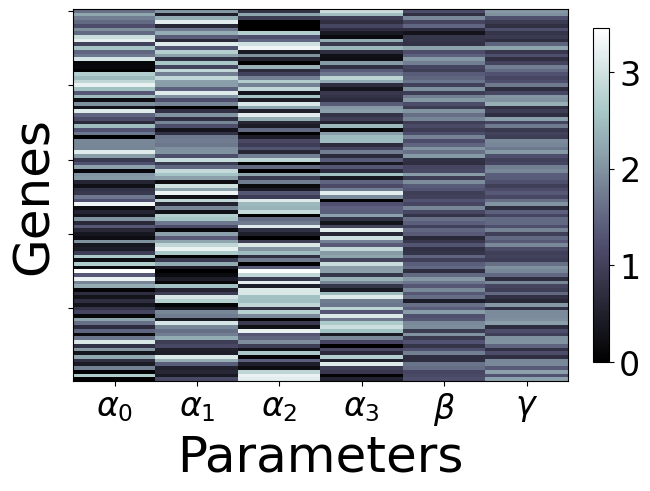

In [14]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(np.log1p(traj.theta),aspect="auto",cmap='bone');
cbar = plt.colorbar(im,fraction=0.2, shrink = 0.9) # adding the colobar on the right

x_label_list = [r'$\alpha_0$', r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', r'$\beta$',r'$\gamma$']
ax.set_xticks([0,1,2,3,4,5]);
ax.set_xticklabels(x_label_list,fontsize=24);

ax.set_yticklabels([],fontsize=24);
ax.set_xlabel('Parameters',fontsize=36)
ax.set_ylabel('Genes',fontsize=36)

Text(0, 0.5, 'values')

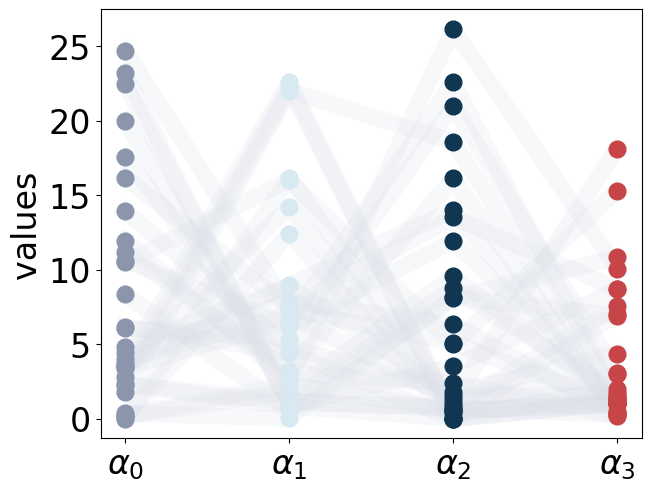

In [15]:
p = X.shape[1]
fig,ax = plt.subplots(1,1)
p_ = 30
for j in range(p_):
    ax.plot(traj.theta[j,[0,1,2,3]],'o-',color='#d9dee7',alpha=0.2)

colors=['#8b96ad','#d8e9f2','#113652','#c74546']
for j in range(4):
    ax.plot([j]*p_,traj.theta[:p_,j],'o',color=colors[j])
    

x_label_list = [r'$α_0$', r'$α_1$', r'$α_2$', r'$α_3$']
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(x_label_list,fontsize=24)
ax.set_ylabel('values',fontsize=24)

# Cluster limit

By setting the splicing and degradation rates to large values, we approach the cluster limit. Here we show that trajectory model naturally incorporates the Poisson mixture model.

## trajectory --> cluster


In [16]:
from Chronocell.models.two_species_ss import get_Y

np.random.seed(0)
loga_max = 4
logb_max = 2

n=1000
p=100
topo = np.array([[0,1,2],[0,1,3]])
tau = (0,1,2)

L=len(topo)
n_states=len(set(topo.flatten()))
t=np.linspace(tau[0],tau[-1],n)
true_t = []

theta=np.zeros((p,n_states+2))
for j in range(n_states):
    theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2:]=1e6*np.exp(np.random.uniform(0,logb_max,size=(p,2)))

Y = np.zeros((n*L,p,2))
for l in range(L):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
    Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
    true_t = np.append(true_t,t)

X = np.random.poisson(Y)

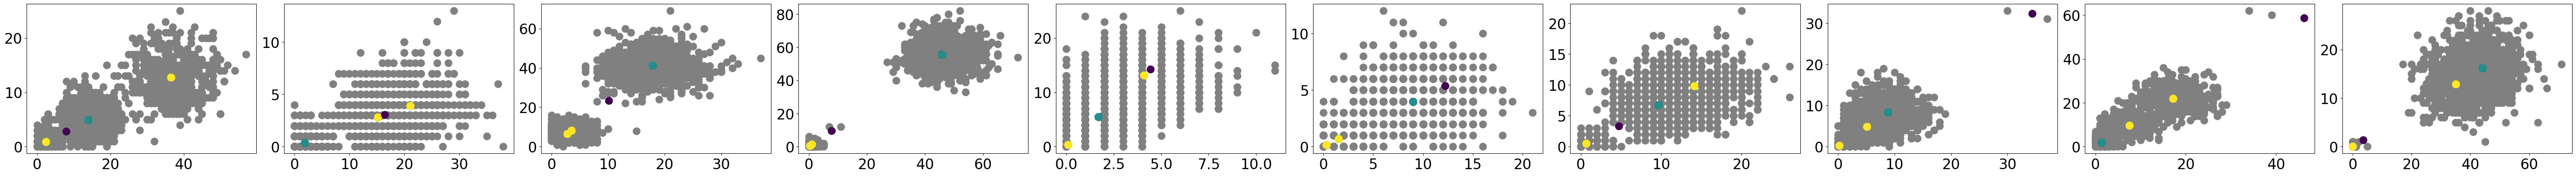

In [17]:
t = np.linspace(tau[0],tau[-1],n)
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t)
    #ax[i].scatter(Y[n:,i,0],Y[n:,i,1],c=true_t[n:],cmap=cmap_2, vmin=tau[0], vmax=tau[-1]);
    #ax[i].scatter(Y[:n//2,i,0],Y[:n//2,i,1],c=t[:n//2],cmap="Purples", vmin=tau[0], vmax=tau[-1]);
# time increases from blue to red

In [18]:
traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj = traj.fit(X,warm_start=True,theta=theta,m=1001,epoch=0)

Reminder: provide cellwise read depth estimates in params with key r
fitting with warm start


0it [00:00, ?it/s]


In [19]:
theta0 = np.zeros((100,5))
theta0[:,:-1] = theta[:,:4]
theta0[:,-1] = theta[:,-2]/theta[:,-1]
PMSS = PoissonMixtureSS(n_components=4)
Q, lower_bound = PMSS.fit(X, warm_start=True, weights=np.array([0.001,0.499,0.25,0.25]), theta=theta0, epoch=0)

In [20]:
lower_bound,traj.elbos[0]

(-442.39930034378045, -442.3993008247555)

In [21]:
def simulate_static_data(n_states, n=10000, p=200, loga_mu=1, loga_sd=1, logb_mu=2, logb_sd=0.5, phi=0, random_seed=42, loomfilepath=None):    
    np.random.seed(random_seed)
    theta=np.zeros((p,n_states+2))
    for j in range(n_states):
        theta[:,j]=np.random.lognormal(loga_mu,loga_sd,size=p)
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    theta[:,-1]/=np.exp(1.5)
           
    Y = np.zeros((n_states,p,2))
    Y[:,:,0]=theta[:,:n_states].T
    Y[:,:,1]=(theta[:,-2]/theta[:,-1])[None,:]*Y[:,:,0]

    idx = np.random.randint(0,n_states,size=n)
    Z = Y[idx]
    
    if phi > 0:
        g_phi = np.random.lognormal(np.log(phi),size=(p//2,2))
        p_idx = np.random.choice(p,size=p//2,replace=False)
        Z[:,p_idx] *= np.random.gamma(shape=1/g_phi,scale=g_phi,size=(n,p//2,2))

    rd_mu, rd_var = 0.25, 0.25
    a = (1-rd_mu)/rd_var - rd_mu
    b = (1/rd_mu-1)*a
    rd = np.random.beta(a=a, b=b, size=n)
    X = np.random.poisson(rd[:,None,None]*Z)
    
    if loomfilepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1))
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["true_time"]=idx
        adata.obs["cell_type"]=idx
        adata.obs["read_depth"]=rd
        adata.uns["true_theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write_loom(loomfilepath)

    return theta, idx, rd, Z, X

theta, idx, rd, Y, X = simulate_static_data(4,n=10000,p=200,phi=0,random_seed=0)#,loomfilepath='data/simulation_4_clusters.loom')

In [22]:
theta0 = np.zeros((200,5))
theta0[:,:-1] = theta[:,:4]
theta0[:,-1] = theta[:,-2]/theta[:,-1]

PMSS = PoissonMixtureSS(n_components=4,verbose=1)
Q, lower_bound = PMSS.fit(X, warm_start=True, theta=theta0, read_depth=rd, epoch=0)
lower_bound

read_depth is not normalized


0it [00:00, ?it/s]


-236.39325229344163

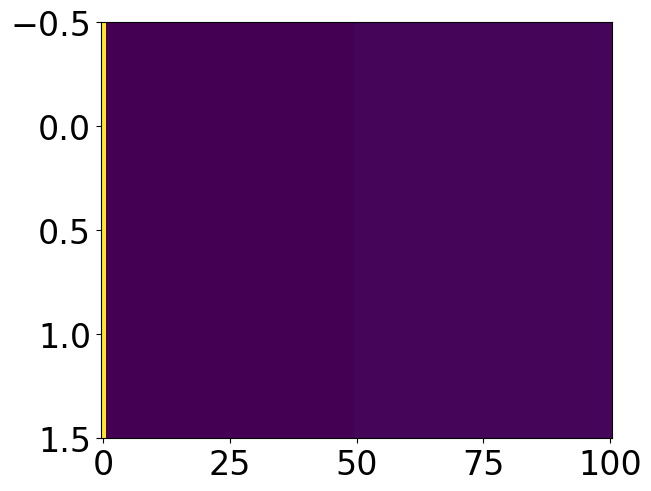

In [23]:
m=101
weights = np.ones(m)
weight_0 = 0.25
weights[0] *= weight_0
weights[1:m//2] *= 0.25/weights[1:m//2].sum()
weights[m//2:] *= 0.5/weights[m//2:].sum()
weights = np.array([0.5,0.5]).reshape((-1,1))@weights.reshape((1,-1))
plt.imshow(weights,aspect="auto");

In [24]:
traj = Trajectory(topo, tau=(0,1,3), model="two_species_ss", verbose=1)
traj = traj.fit(X,warm_start=True,prior=weights,theta=theta,params={'r':rd,'bnd_beta':1e6},m=m,epoch=20,n_threads=4)
traj.elbos

fitting with warm start


100%|██████████| 20/20 [02:50<00:00,  8.52s/it]


[-242.52967935989918,
 -237.12236083216933,
 -236.8363391772203,
 -236.69812363358918,
 -236.6219705696281,
 -236.5744152455445,
 -236.54404675401136,
 -236.5262213892703,
 -236.51646878721263,
 -236.51053830741918,
 -236.51691328763306,
 -236.49029712137133,
 -236.49205286189598,
 -236.5116519942768,
 -236.5029563715121,
 -236.48192728975374,
 -236.51099024871624,
 -236.4662556890906,
 -236.48930387269874,
 -237.0088827196098,
 -236.98662224099283]